#### Read Data

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, date_format, dayofweek, month, count, avg, max, min, to_date, to_timestamp, sum, when, dayofweek

In [2]:
spark = SparkSession.builder.appName('App')\
        .config("spark.executor.cores",'16')\
        .config("spark.executor.memory", '60g')\
        .getOrCreate()

In [3]:
df2021 = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_Data_full.csv")
df2020 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2020_Yellow_Taxi_Trip_Data_full.csv")
df2019 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2019_Yellow_Taxi_Trip_Data_full.csv")

#### Sampling Data

In [4]:
sampled_2021 = df2021.sample(fraction=0.001, seed=12)
sampled_2020 = df2020.sample(fraction=0.001, seed=34)
sampled_2019 = df2019.sample(fraction=0.001, seed=56)

In [5]:
sampled_2021 = sampled_2021.withColumn("Datayear", lit(2021))
sampled_2020 = sampled_2020.withColumn("Datayear", lit(2020))
sampled_2019 = sampled_2019.withColumn("Datayear", lit(2019))

In [6]:
print(sampled_2021 .count(),len(sampled_2021 .columns))

31103 19


In [7]:
sampled_2021.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)



In [8]:
sampled_2021.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|       2|01/01/2021 01:45:...| 01/01/2021 02:00:...|              1|         4.62|         1|                 N|          50|          74|           2|       15.5|  0.5|    0.5|       0.0|       

In [9]:
union_df = sampled_2021.union(sampled_2020).union(sampled_2019)

#### Check Number of Partitions - Equally partitioned

In [10]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

In [11]:
#number of partitions
union_df.rdd.getNumPartitions()

103

In [12]:
#re-partition the data to evenly distributed across 8 partitions
union_df = union_df.repartition(8)
displaypartitions(union_df)

Partitions: 8


+-----------+-----+
|partitionId|count|
+-----------+-----+
|          5|17501|
|          4|17511|
|          3|17521|
|          2|17536|
|          1|17548|
|          0|17565|
|          7|17575|
|          6|17590|
+-----------+-----+



#### Feature Engineering

In [13]:
# change to date type
union_df = union_df.withColumn("parsed_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df = union_df.withColumn("parsed_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)



In [14]:
# calcualte average spent per mile and avergae spent per min
union_df = union_df.withColumn("PerMile", col("total_amount") / col("trip_distance"))

#df2021Full = df2021Full.withColumn("Dur",  col("parsed_dropoff_datetime") - col("parsed_pickup_datetime"))
from pyspark.sql.functions import datediff, minute, hour
union_df = union_df.withColumn("Dur", datediff("parsed_dropoff_datetime", "parsed_pickup_datetime") * 24 * 60 +hour("parsed_dropoff_datetime")* 60-hour("parsed_pickup_datetime")*60
+ minute("parsed_dropoff_datetime") - minute("parsed_pickup_datetime"))

union_df = union_df.withColumn("PerMin", col("total_amount") / col("Dur"))

In [15]:
union_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+----------------------+-----------------------+------------------+---+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|parsed_pickup_datetime|parsed_dropoff_datetime|           PerMile|Dur|            PerMin|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+-------------------

In [16]:
Avg_Spent_vendor = union_df.groupBy("VendorID") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("Avg spent per mile").desc()) 
                           
Avg_Spent_vendor.show()
# vendor 4 is the most expensive provider

+--------+------------------+------------------+
|VendorID|Avg spent per mile| Avg spent per min|
+--------+------------------+------------------+
|       2|12.591149718683493|1.6423923531078626|
|    null|10.892044604974704|1.6971111991845373|
|       1|10.081060477605583|1.6612353016642667|
|       4| 9.767846459965194|1.5615209390157712|
|       6| 9.625610632675022|0.6959078816332338|
+--------+------------------+------------------+



In [17]:
# Extract the hour from pickup time
union_df = union_df.withColumn("pickup_hour", hour("parsed_pickup_datetime"))

In [18]:
Avg_Spent_hour = union_df.groupBy("pickup_hour") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("pickup_hour").desc()) 

In [19]:
Avg_Spent_hour.show()

+-----------+------------------+------------------+
|pickup_hour|Avg spent per mile| Avg spent per min|
+-----------+------------------+------------------+
|         23| 9.935819435975175|1.7402768091372476|
|         22|10.995118368474543|1.7236848024589917|
|         21|12.289196434612604|1.7712451798472513|
|         20|10.588669124329488|1.7341131653247062|
|         19|11.461037148455024| 1.720701638093871|
|         18|12.773027629113573|1.6394553666969212|
|         17|10.921481927429607| 1.599492392103511|
|         16|11.272648529947826|1.6186467171164955|
|         15| 12.96836317285149|1.4718110015685937|
|         14|11.646970462263997|1.4839013636741876|
|         13|14.663887519284723|1.5671042607164634|
|         12|12.499804013606296|  1.54900127202034|
|         11|10.028118488403543|1.5113655473719723|
|         10|13.260097908382125|1.5484395616658504|
|          9|12.503875826056282| 1.617415651117296|
|          8|12.485117405923994|1.6159460654163489|
|          7

In [20]:
Spent_hour_plot=Avg_Spent_hour.toPandas()

In [21]:
Spent_hour_plot

# somthing off when pickup_hour =4

,pickup_hour,Avg spent per mile,Avg spent per min
0,23,9.935819,1.740277
1,22,10.995118,1.723685
2,21,12.289196,1.771245
3,20,10.588669,1.734113
4,19,11.461037,1.720702
5,18,12.773028,1.639455
6,17,10.921482,1.599492
7,16,11.272649,1.618647
8,15,12.968363,1.471811
9,14,11.646970,1.483901


<AxesSubplot:xlabel='pickup_hour'>

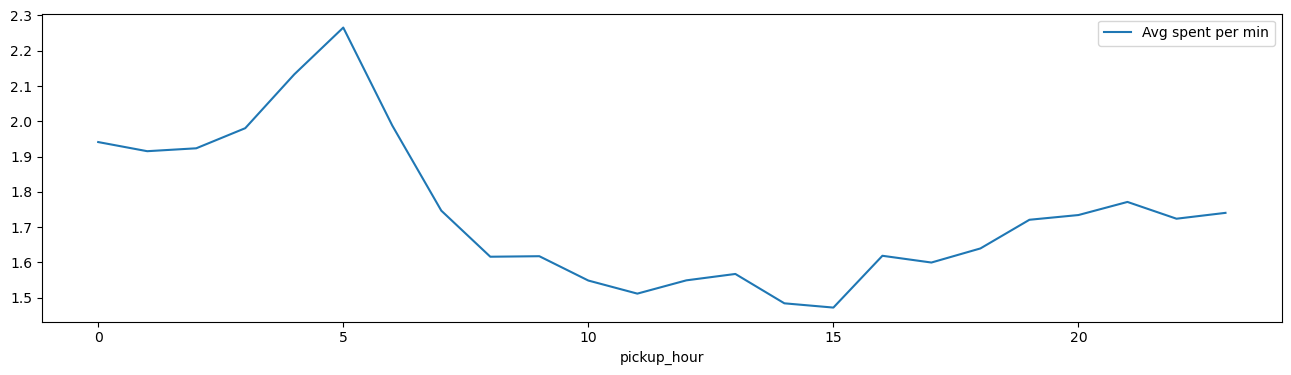

In [22]:
Spent_hour_plot.plot(y='Avg spent per min', x ='pickup_hour',figsize=(16,4))

<AxesSubplot:xlabel='pickup_hour'>

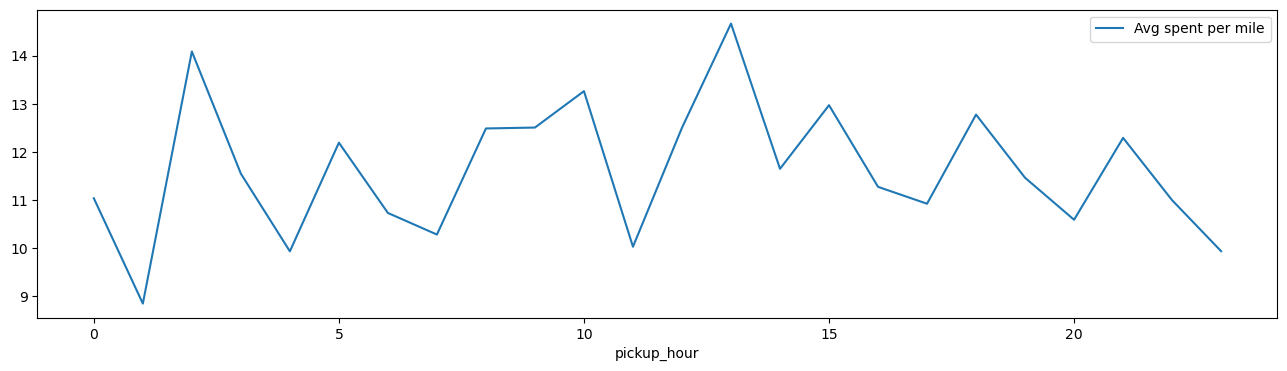

In [23]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', figsize=(16,4))

<AxesSubplot:xlabel='pickup_hour'>

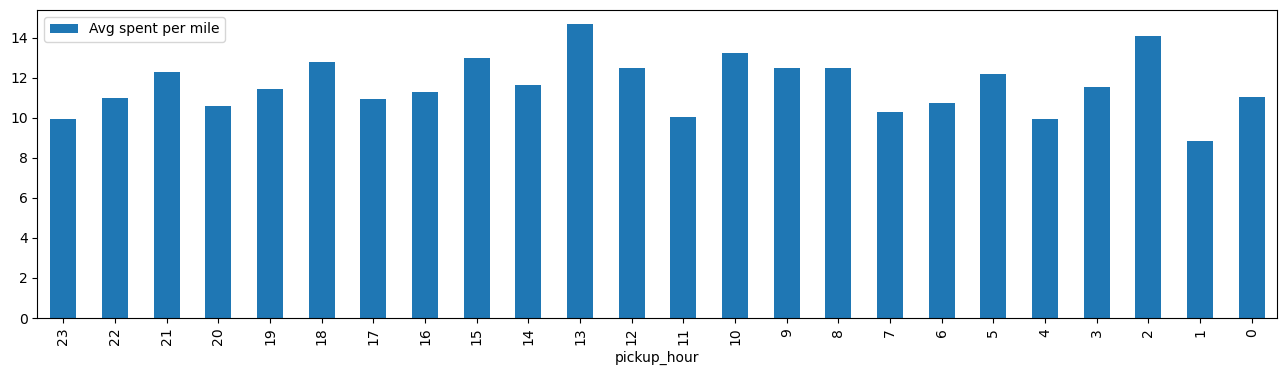

In [24]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', kind='bar', figsize=(16,4))

#### Fair Amount vs trip distance EDA

In [25]:
fare_distance_df = union_df.select("fare_amount", "trip_distance").toPandas()

In [26]:
fare_distance_df.describe()

,fare_amount,trip_distance
count,140276.000000,140276.000000
mean,13.224245,3.542678
std,12.242471,191.918126
min,-120.000000,-23.350000
25%,6.500000,1.000000
50%,9.500000,1.700000
75%,14.500000,3.100000
max,657.000000,71866.760000


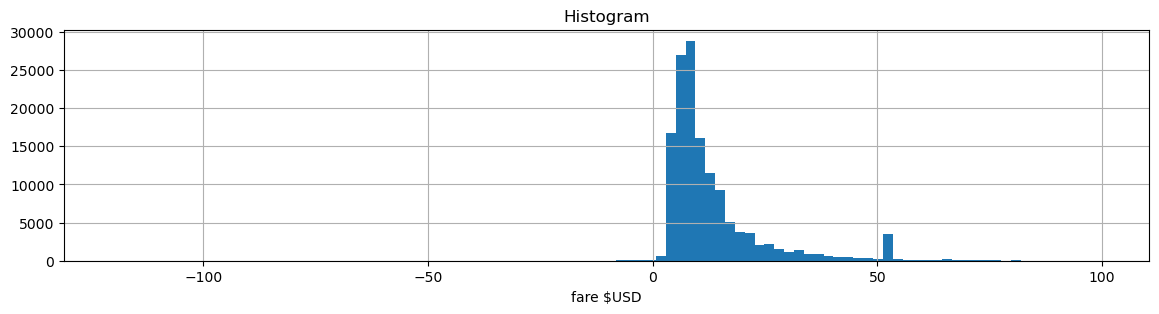

In [27]:
import matplotlib.pyplot as plt
# plot histogram of fare amount
fare_distance_df[fare_distance_df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

Looks like there are some negative fare amounts. Remove them from the union_df.

Upon research, the taxi fare's initial charge is $3.0, so we are removing fare amount smaller than this amount.

In [28]:
# Filter for fare_amount >=3.0
union_df = union_df.filter(condition = col("fare_amount") >= 3.0)

In [29]:
fare_distance_df = union_df.select("fare_amount", "trip_distance").toPandas()

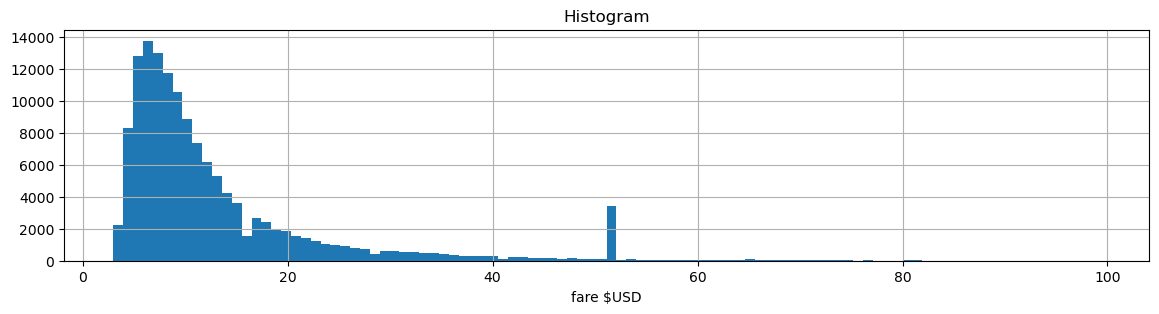

In [30]:
import matplotlib.pyplot as plt
# plot histogram of fare amount
fare_distance_df[fare_distance_df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In the histogram of the fare_amount there is a big spike around $50. This could indicate some fixed fare price (e.g. to/from airport).

In [31]:
# Check for missing values in a fare column
union_df.select([count(when(col("fare_amount").isNull(), "fare_amount")).alias("missing_fare_amount")]).show()

+-------------------+
|missing_fare_amount|
+-------------------+
|                  0|
+-------------------+



In [32]:
fare_distance_df.describe()

,fare_amount,trip_distance
count,139099.000000,139099.000000
mean,13.373434,3.090076
std,12.336893,16.687423
min,3.000000,-18.150000
25%,6.500000,1.000000
50%,9.500000,1.700000
75%,15.000000,3.110000
max,657.000000,6016.060000


In [33]:
# Remove the outliers
fare_distance_df = fare_distance_df[(fare_distance_df['trip_distance'] >= 0) & (fare_distance_df['trip_distance'] <= 500)]
# Show the new summary statistics
print(fare_distance_df['trip_distance'].describe())

count    139082.000000
mean          3.043791
std           3.992306
min           0.000000
25%           1.000000
50%           1.700000
75%           3.110000
max         241.200000
Name: trip_distance, dtype: float64


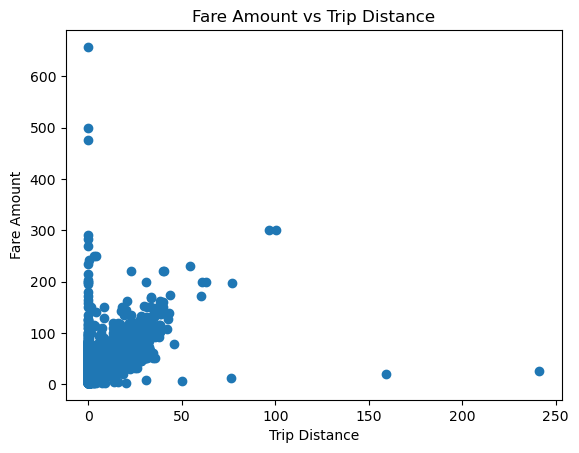

In [34]:
plt.scatter(fare_distance_df["trip_distance"], fare_distance_df["fare_amount"])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Fare Amount vs Trip Distance")
plt.show()

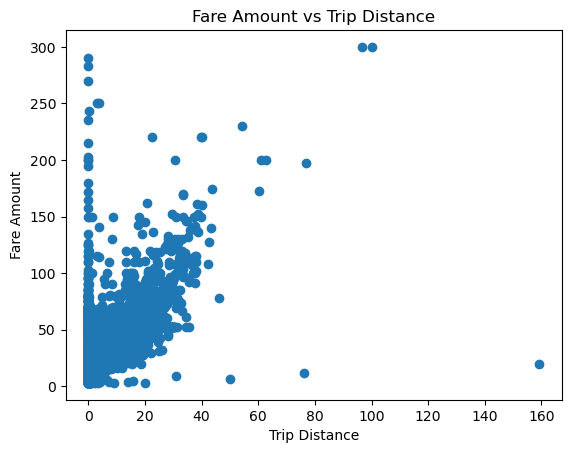

In [35]:
import numpy as np
# Filter out extreme points
fare_distance_df = fare_distance_df[(fare_distance_df['trip_distance'] <200) & (fare_distance_df['fare_amount'] < 400)]

plt.scatter(fare_distance_df["trip_distance"], fare_distance_df["fare_amount"])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Fare Amount vs Trip Distance")
plt.show()

Most Fare Amounts increase as trip distance increases. Interestingly, there are many trips with 0 trip distance but high fare amounts. One possible explanation may be that those trips have the same pickup and dropoff location, and the trip distance was calculated based on the pickup and dropoff zone records.

#### Visualize the pickup & dropoff locations

In [36]:
union_df.select('PULocationID','DOLocationID').show()

+------------+------------+
|PULocationID|DOLocationID|
+------------+------------+
|         236|         163|
|         236|         141|
|          68|          90|
|         132|          90|
|         236|         237|
|         236|         237|
|         170|         162|
|          90|         107|
|         237|          43|
|         116|          42|
|         141|         186|
|          74|         142|
|         170|         237|
|          79|           4|
|          48|         158|
|         114|          79|
|         140|          43|
|         237|         100|
|         236|         234|
|         186|         145|
+------------+------------+
only showing top 20 rows



In [37]:
# Read taxi_zone data to get longitude/latitude data
import geopandas as gpd
import pandas as pd

# Read the shapefile into a geopandas dataframe
gdf = gpd.read_file("gs://project_hynr2/taxi_zones.zip")

# Convert the geopandas dataframe to a pandas dataframe
df = gdf.drop(columns='geometry')
df[['longitude', 'latitude']] = gdf['geometry'].apply(lambda p: pd.Series(p.centroid.coords[0]))

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [38]:
df

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.359968e+05,191376.749531
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.031086e+06,164018.754403
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.026453e+06,254265.478659
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.906340e+05,202959.782391
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.318714e+05,140681.351376
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.025106e+06,266453.414552
259,260,0.133514,0.000422,Woodside,260,Queens,1.010212e+06,210434.891894
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.806395e+05,197635.173702
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.990647e+05,221974.400788


In [39]:
df = df.drop(columns = 'OBJECTID')

In [40]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# define the schema of the PySpark DataFrame
schema = StructType([
    StructField("Shape_Leng", DoubleType()),
    StructField("Shape_Area", DoubleType()),
    StructField("zone", StringType()),
    StructField("LocationID", IntegerType()),
    StructField("borough", StringType()),
    StructField("longitude", DoubleType()),
    StructField("latitude", DoubleType())
])

# convert the pandas DataFrame to PySpark DataFrame
taxi_zone = spark.createDataFrame(df, schema=schema)

In [41]:
taxi_zone.printSchema()

root
 |-- Shape_Leng: double (nullable = true)
 |-- Shape_Area: double (nullable = true)
 |-- zone: string (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)



In [64]:
taxi_zone.show()

+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|     Shape_Leng|      Shape_Area|                zone|LocationID|      borough|         longitude|          latitude|
+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR| 935996.8210162065|191376.74953083202|
|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|1031085.7186032843|164018.75440320166|
|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|1026452.6168734727|254265.47865856893|
|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan| 990633.9806410479| 202959.7823911368|
|0.0921464898574|4.97957489363E-4|       Arden Heights|         5|Staten Island| 931871.3700680139|140681.35137597343|
| 0.150490542523|6.06460984581E-4|Arrochar/Fort 

In [68]:
joined_df = union_df.join(taxi_zone, col("PULocationID") == col("LocationID"),"inner")

In [70]:
joined_df = joined_df.drop('LocationID','Shape_leng','Shape_Area')
joined_df = joined_df.withColumnRenamed("longitude", "PUlongitude")\
            .withColumnRenamed("latitude","PUlatitude")\
            .withColumnRenamed("zone","PUzone")\
            .withColumnRenamed("borough","PUborough")

In [71]:
joined_df = joined_df.join(taxi_zone, col("DOLocationID") == col("LocationID"),"inner")

In [73]:
joined_df = joined_df.drop('LocationID')
joined_df = joined_df.withColumnRenamed("longitude", "DOlongitude")\
            .withColumnRenamed("latitude","DOlatitude")\
            .withColumnRenamed("zone","DOzone")\
            .withColumnRenamed("borough","DOborough")
joined_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: dou

#### Analyze which regions have most pickups and drop-offs?

In [89]:
# Find most pickup locations
from pyspark.sql.functions import desc

most_pickup_loc = joined_df.groupBy('PULocationID','PUzone','PUborough','PUlongitude','PUlatitude') \
                       .count() \
                       .orderBy(desc('count'))

In [90]:
most_pickup_loc.show()

+------------+--------------------+---------+------------------+------------------+-----+
|PULocationID|              PUzone|PUborough|       PUlongitude|        PUlatitude|count|
+------------+--------------------+---------+------------------+------------------+-----+
|         237|Upper East Side S...|Manhattan| 993769.0237137815|219305.82782555217| 6326|
|         236|Upper East Side N...|Manhattan| 996155.3867656847| 223613.7535760244| 5742|
|         161|      Midtown Center|Manhattan|  990428.525989642| 215447.5272239114| 5355|
|         186|Penn Station/Madi...|Manhattan| 986345.3986004688| 211974.4462185665| 4937|
|         162|        Midtown East|Manhattan| 991908.5895678961|214959.58164229896| 4863|
|         230|Times Sq/Theatre ...|Manhattan| 988628.0600467023| 216099.1397683868| 4302|
|         170|         Murray Hill|Manhattan| 990209.6000586881|211701.31597992923| 4280|
|         142| Lincoln Square East|Manhattan| 989365.0684741095| 221132.7753491493| 4251|
|         

In [80]:
most_pickup_borough = joined_df.groupBy('PUborough') \
                       .count() \
                       .orderBy(desc('count'))

In [81]:
most_pickup_borough.show()

+-------------+------+
|    PUborough| count|
+-------------+------+
|    Manhattan|126281|
|       Queens|  8973|
|     Brooklyn|  1699|
|        Bronx|   425|
|          EWR|     8|
|Staten Island|     6|
+-------------+------+



In [82]:
# Find most pickup locations
most_dropoff_loc = joined_df.groupBy('DOLocationID','DOzone','DOborough','DOlongitude','DOlatitude') \
                       .count() \
                       .orderBy(desc('count'))

In [83]:
most_dropoff_loc.show()

+------------+--------------------+---------+-----------------+------------------+-----+
|DOLocationID|              DOzone|DOborough|      DOlongitude|        DOlatitude|count|
+------------+--------------------+---------+-----------------+------------------+-----+
|         236|Upper East Side N...|Manhattan|996155.3867656847| 223613.7535760244| 5875|
|         237|Upper East Side S...|Manhattan|993769.0237137815|219305.82782555217| 5673|
|         161|      Midtown Center|Manhattan| 990428.525989642| 215447.5272239114| 5073|
|         170|         Murray Hill|Manhattan|990209.6000586881|211701.31597992923| 4351|
|         162|        Midtown East|Manhattan|991908.5895678961|214959.58164229896| 4027|
|         142| Lincoln Square East|Manhattan|989365.0684741095| 221132.7753491493| 3745|
|         230|Times Sq/Theatre ...|Manhattan|988628.0600467023| 216099.1397683868| 3697|
|         239|Upper West Side S...|Manhattan|990167.4982917221|224895.87216479488| 3680|
|         141|     Le

In [86]:
# Find most pickup locations
most_dropoff_borough = joined_df.groupBy('DOborough') \
                       .count() \
                       .orderBy(desc('count'))

In [87]:
most_dropoff_borough.show()

+-------------+------+
|    DOborough| count|
+-------------+------+
|    Manhattan|122993|
|       Queens|  6929|
|     Brooklyn|  5861|
|        Bronx|  1216|
|          EWR|   295|
|Staten Island|    48|
+-------------+------+



Both Top 20 pickup & Top 20 dropoff locations are in Manhattan borough.

In [91]:
pickup_df = most_pickup_loc.toPandas()
dropoff_df = most_dropoff_loc.toPandas()

In [94]:
pu_borough = most_pickup_borough.toPandas()
do_borough = most_dropoff_borough.toPandas()

In [92]:
pickup_df

,PULocationID,PUzone,PUborough,PUlongitude,PUlatitude,count
0,237,Upper East Side South,Manhattan,9.937690e+05,219305.827826,6326
1,236,Upper East Side North,Manhattan,9.961554e+05,223613.753576,5742
2,161,Midtown Center,Manhattan,9.904285e+05,215447.527224,5355
3,186,Penn Station/Madison Sq West,Manhattan,9.863454e+05,211974.446219,4937
4,162,Midtown East,Manhattan,9.919086e+05,214959.581642,4863
...,...,...,...,...,...,...
228,153,Marble Hill,Manhattan,1.009035e+06,258429.141535,1
229,59,Crotona Park,Bronx,1.013308e+06,244801.239917,1
230,178,Ocean Parkway South,Brooklyn,9.924883e+05,164182.164211,1
231,31,Bronx Park,Bronx,1.018696e+06,251801.913395,1


In [93]:
dropoff_df

,DOLocationID,DOzone,DOborough,DOlongitude,DOlatitude,count
0,236,Upper East Side North,Manhattan,9.961554e+05,223613.753576,5875
1,237,Upper East Side South,Manhattan,9.937690e+05,219305.827826,5673
2,161,Midtown Center,Manhattan,9.904285e+05,215447.527224,5073
3,170,Murray Hill,Manhattan,9.902096e+05,211701.315980,4351
4,162,Midtown East,Manhattan,9.919086e+05,214959.581642,4027
...,...,...,...,...,...,...
247,109,Great Kills,Staten Island,9.423181e+05,140370.836973,1
248,111,Green-Wood Cemetery,Brooklyn,9.869598e+05,176867.702606,1
249,30,Broad Channel,Queens,1.033697e+06,159266.086884,1
250,99,Freshkills Park,Staten Island,9.324636e+05,149465.339575,1


In [95]:
pu_borough

,PUborough,count
0,Manhattan,126281
1,Queens,8973
2,Brooklyn,1699
3,Bronx,425
4,EWR,8
5,Staten Island,6


In [96]:
do_borough

,DOborough,count
0,Manhattan,122993
1,Queens,6929
2,Brooklyn,5861
3,Bronx,1216
4,EWR,295
5,Staten Island,48


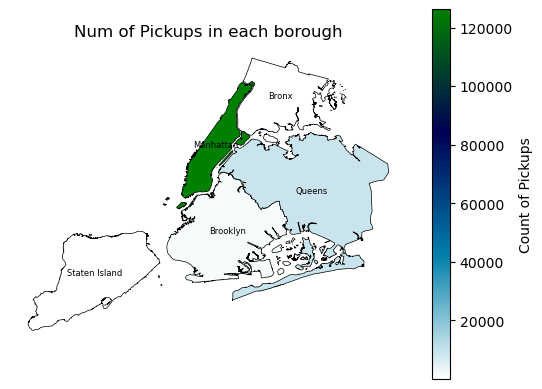

In [115]:
dobo_df = pu_borough

# Merge the data with the NYC shapefile
merged = nyc_shapefile.merge(dobo_df, left_on='boro_name', right_on='PUborough')

# Create a choropleth map of the count of dropoff trips in each DOborough
ax = merged.plot(column='count', cmap='ocean_r', edgecolor='k', linewidth=0.5, legend=True, legend_kwds={'label': "Count of Pickups"})
ax.set_title("Num of Pickups in each borough")

# Remove axes and set aspect ratio to equal
ax.set_axis_off()
ax.set_aspect('equal')

# Loop through each geometry in the GeoDataFrame and add a text label at the centroid
for idx, row in merged.iterrows():
    ax.annotate(text=row['PUborough'], xy=row['geometry'].centroid.coords[0], color='black', fontsize=6, ha='center')

# Show the plot
plt.show()

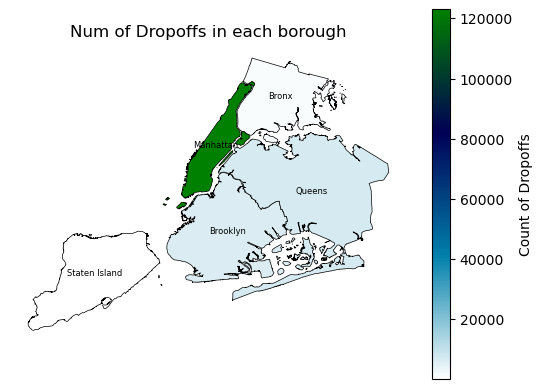

In [113]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load the NYC shapefile using geopandas
nyc_shapefile = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile")

dobo_df = do_borough

# Merge the data with the NYC shapefile
merged = nyc_shapefile.merge(dobo_df, left_on='boro_name', right_on='DOborough')

# Create a choropleth map of the count of dropoff trips in each DOborough
ax = merged.plot(column='count', cmap='ocean_r', edgecolor='k', linewidth=0.5, legend=True, legend_kwds={'label': "Count of Dropoffs"})
ax.set_title("Num of Dropoffs in each borough")

# Remove axes and set aspect ratio to equal
ax.set_axis_off()
ax.set_aspect('equal')

# Loop through each geometry in the GeoDataFrame and add a text label at the centroid
for idx, row in merged.iterrows():
    ax.annotate(text=row['DOborough'], xy=row['geometry'].centroid.coords[0], color='black', fontsize=6, ha='center')
    
# Show the plot
plt.show()

In [135]:
# import numpy as np

# # Define the range we want to map the columns to
# new_min_lon, new_max_lon = -74.5, -72.8
# new_min_lat, new_max_lat = 40.5, 41.8

# # Get the minimum and maximum values of the columns
# original_min_lon, original_max_lon = pickup_df['PUlongitude'].min(), pickup_df['PUlongitude'].max()
# original_min_lat, original_max_lat = pickup_df['PUlatitude'].min(), pickup_df['PUlatitude'].max()

# # Normalize the columns using the formula
# pickup_df['PUlongitude_norm'] = (pickup_df['PUlongitude'] - original_min_lon) * (new_max_lon - new_min_lon) / (original_max_lon - original_min_lon) + new_min_lon
# pickup_df['PUlatitude_norm'] = (pickup_df['PUlatitude'] - original_min_lat) * (new_max_lat - new_min_lat) / (original_max_lat - original_min_lat) + new_min_lat

In [136]:
# pickup_df

In [137]:
# import folium
# from folium.plugins import HeatMap

# pickup_map = folium.Map(location=[40.75, -73.98], zoom_start=13)

# for index, row in pickup_df.iterrows():
#     count = row['count']
#     lat = row['PUlatitude_norm']
#     lon = row['PUlongitude_norm']
#     tooltip = f"{count} pickups"
#     marker = folium.Marker(location=[lat, lon], tooltip=tooltip)
#     marker.add_to(pickup_map)

# pickup_map

In [54]:
# def select_within_boundingbox_pu(df, BB):
#     return (df['PUlongitude'] >= BB[0]) & (df['PUlongitude'] <= BB[1]) & \
#            (df['PUlatitude'] >= BB[2]) & (df['PUlatitude'] <= BB[3])
           
# def select_within_boundingbox_do(df, BB):
#     return (df['DOlongitude'] >= BB[0]) & (df['DOlongitude'] <= BB[1]) & \
#            (df['DOlatitude'] >= BB[2]) & (df['DOlatitude'] <= BB[3])

In [55]:
# pickup_df = pickup_df[select_within_boundingbox_pu(pickup_df, BB_zoom)]
# dropoff_df = dropoff_df[select_within_boundingbox_do(dropoff_df, BB_zoom)]

In [56]:
# BB_zoom = (-74.3, -73.7, 40.5, 40.9)

In [57]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Load the NYC shapefile using geopandas
# nyc_shapefile = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile")

# # Create a geopandas dataframe from the taxi location data
# taxi_up_df = gpd.GeoDataFrame(pickup_df, geometry=gpd.points_from_xy(pickup_df['PUlongitude'], pickup_df['PUlatitude']))

# # Set the coordinate reference system to the same as the NYC shapefile
# taxi_up_df.crs = nyc_shapefile.crs

# # Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# # Plot the data on the NYC map using geoplot
# nyc_shapefile.plot(ax=ax1, alpha=0.2, edgecolor='k')
# taxi_up_df.plot(ax=ax1, markersize=2, color='red')

# # Plot the data on the zoomed-in map using geoplot
# select_within_boundingbox(taxi_up_df, BB_zoom).plot(ax=ax2, markersize=2, color='red')

# # Set the x and y limits for both plots
# ax1.set_xlim(BB[0], BB[1])
# ax1.set_ylim(BB[2], BB[3])
# ax2.set_xlim(BB_zoom[0], BB_zoom[1])
# ax2.set_ylim(BB_zoom[2], BB_zoom[3])

# # Set titles for both plots
# ax1.set_title('NYC Taxi Pickups')
# ax2.set_title('Zoomed-in NYC Taxi Pickups')

# # Show the plot
# plt.show()

#### Peak hours and Off-peak hours for taking taxi

In [140]:
union_df = union_df.withColumn('pu_hour',hour('parsed_pickup_datetime'))

In [141]:
union_df = union_df.withColumn('do_hour',hour('parsed_dropoff_datetime'))

In [153]:
pu_hour_df = union_df.groupby('pu_hour')\
            .agg(F.count('*').alias('PU_count')).orderBy('pu_hour')
do_hour_df = union_df.groupby('do_hour')\
            .agg(F.count('*').alias('DO_count')).orderBy('do_hour')

In [154]:
pu_df = pu_hour_df.toPandas()
do_df = do_hour_df.toPandas()

In [155]:
pu_df

,pu_hour,PU_count
0,0,3669
1,1,2474
2,2,1709
3,3,1207
4,4,929
5,5,1142
6,6,2681
7,7,4918
8,8,6292
9,9,6550


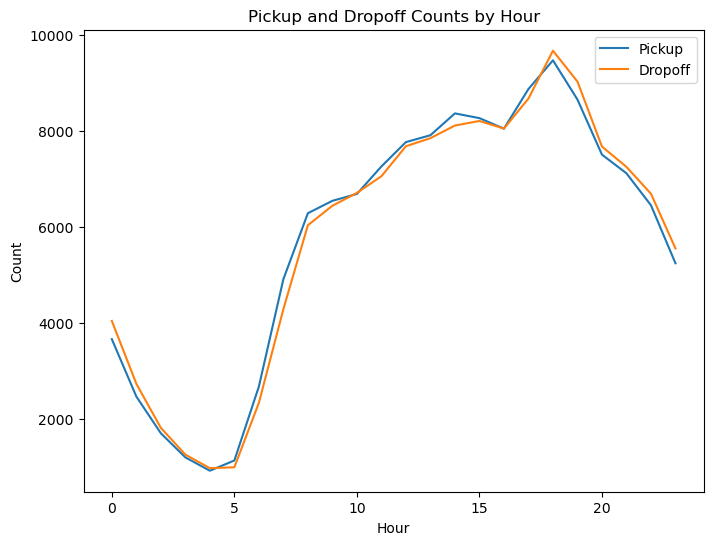

In [156]:
# Plot pickup and dropoff counts on the same plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(pu_df['pu_hour'], pu_df['PU_count'], label='Pickup')
ax.plot(do_df['do_hour'], do_df['DO_count'], label='Dropoff')

ax.set_title('Pickup and Dropoff Counts by Hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

ax.legend()
plt.show()

Pickup and Dropoff has about the same counts by hour, with 4-5 am being the most off-peak hours and 4pm to 7pm being the peak-hours.

May also check seasonality(quarterly patterns) or year patterns (given we have 3 years).

#### Zone with most pickups for short trips/ zone with most pickups for long trips

In [158]:
union_df.select('trip_distance').describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|            139269|
|   mean| 3.562771471038067|
| stddev|192.61054669443882|
|    min|            -18.15|
|    max|          71866.76|
+-------+------------------+



According to the dustribution of trip distances (very right skewed) and the fact that it takes about 30 miles to drive across the whole New York City, we decided to use 30 as the number to split the trips into short or long distance trips.

Will need to adjust threshold when using FULL Dataset

In [178]:
short_trip = joined_df.filter(F.col('trip_distance')<30)

In [179]:
long_trip = joined_df.filter(F.col('trip_distance')>= 30)

In [195]:
from pyspark.sql.functions import desc
short_trip_PUzone = short_trip.groupby('PULocationID','PUzone','PUborough')\
                    .count().orderBy(desc('count'))

In [196]:
long_trip_PUzone = long_trip.groupby('PULocationID','PUzone','PUborough')\
                    .count().orderBy(desc('count'))

In [197]:
short_trip_DOzone = short_trip.groupby('DOLocationID','DOzone','DOborough')\
                    .count().orderBy(desc('count'))

In [198]:
long_trip_DOzone = long_trip.groupby('DOLocationID','DOzone','DOborough')\
                    .count().orderBy(desc('count'))

In [199]:
short_trip_PUzone.show()

+------------+--------------------+---------+-----+
|PULocationID|              PUzone|PUborough|count|
+------------+--------------------+---------+-----+
|         237|Upper East Side S...|Manhattan| 6278|
|         236|Upper East Side N...|Manhattan| 5870|
|         161|      Midtown Center|Manhattan| 5396|
|         186|Penn Station/Madi...|Manhattan| 4921|
|         162|        Midtown East|Manhattan| 4881|
|         170|         Murray Hill|Manhattan| 4308|
|         142| Lincoln Square East|Manhattan| 4267|
|         230|Times Sq/Theatre ...|Manhattan| 4258|
|         132|         JFK Airport|   Queens| 4188|
|          48|        Clinton East|Manhattan| 4181|
|         234|            Union Sq|Manhattan| 3971|
|         239|Upper West Side S...|Manhattan| 3739|
|         163|       Midtown North|Manhattan| 3648|
|         141|     Lenox Hill West|Manhattan| 3557|
|          79|        East Village|Manhattan| 3521|
|          68|        East Chelsea|Manhattan| 3253|
|         13

In [200]:
long_trip_PUzone.show()

+------------+--------------------+-------------+-----+
|PULocationID|              PUzone|    PUborough|count|
+------------+--------------------+-------------+-----+
|         132|         JFK Airport|       Queens|   12|
|         158|Meatpacking/West ...|    Manhattan|    2|
|         138|   LaGuardia Airport|       Queens|    2|
|         216|    South Ozone Park|       Queens|    2|
|         186|Penn Station/Madi...|    Manhattan|    2|
|         247|      West Concourse|        Bronx|    1|
|         100|    Garment District|    Manhattan|    1|
|         135|   Kew Gardens Hills|       Queens|    1|
|         116|    Hamilton Heights|    Manhattan|    1|
|          44|Charleston/Totten...|Staten Island|    1|
|         182|         Parkchester|        Bronx|    1|
|          68|        East Chelsea|    Manhattan|    1|
|         236|Upper East Side N...|    Manhattan|    1|
|          55|        Coney Island|     Brooklyn|    1|
|         140|     Lenox Hill East|    Manhattan

Looks like most long trips are picked up from JFL Airports.

In [201]:
short_trip_DOzone.show()

+------------+--------------------+---------+-----+
|DOLocationID|              DOzone|DOborough|count|
+------------+--------------------+---------+-----+
|         236|Upper East Side N...|Manhattan| 5963|
|         237|Upper East Side S...|Manhattan| 5680|
|         161|      Midtown Center|Manhattan| 5064|
|         170|         Murray Hill|Manhattan| 4327|
|         162|        Midtown East|Manhattan| 4008|
|         142| Lincoln Square East|Manhattan| 3758|
|         230|Times Sq/Theatre ...|Manhattan| 3671|
|         141|     Lenox Hill West|Manhattan| 3662|
|         239|Upper West Side S...|Manhattan| 3648|
|          48|        Clinton East|Manhattan| 3640|
|         234|            Union Sq|Manhattan| 3531|
|         186|Penn Station/Madi...|Manhattan| 3354|
|          68|        East Chelsea|Manhattan| 3203|
|         238|Upper West Side N...|Manhattan| 3156|
|         163|       Midtown North|Manhattan| 3134|
|          79|        East Village|Manhattan| 2907|
|         10

In [202]:
long_trip_DOzone.show()

+------------+--------------------+-------------+-----+
|DOLocationID|              DOzone|    DOborough|count|
+------------+--------------------+-------------+-----+
|           1|      Newark Airport|          EWR|   12|
|         132|         JFK Airport|       Queens|    4|
|          87|Financial Distric...|    Manhattan|    2|
|          44|Charleston/Totten...|Staten Island|    2|
|         158|Meatpacking/West ...|    Manhattan|    2|
|           7|             Astoria|       Queens|    1|
|         162|        Midtown East|    Manhattan|    1|
|         138|   LaGuardia Airport|       Queens|    1|
|         252|          Whitestone|       Queens|    1|
|          39|            Canarsie|     Brooklyn|    1|
|         237|Upper East Side S...|    Manhattan|    1|
|         117|     Hammels/Arverne|       Queens|    1|
|         221|           Stapleton|Staten Island|    1|
|          75|   East Harlem South|    Manhattan|    1|
|          55|        Coney Island|     Brooklyn

Most dropoff for long trips are also airports (Newark and JFK).